### NOTE: If running from colab and you have uploaded the folder ERA-V1/era_v1_session7_pankaja then uncomment the two cells below and run before moving on to Install libraries

In [6]:
# from google.colab import drive
# drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
# %cd /gdrive/My\ Drive/ERA-V1/era_v1_session7_pankaja

/gdrive/My Drive/ERA-V1/era_v1_session7_pankaja


### Target:
- Add some capacity (additional FC layer after GAP) to the model and added LR Scheduler

### Results:
- Parameters: 6720
- Best Training Accuracy: 99.43
- Best Test Accuracy: 99.53

### Analysis:
- The model parameters have increased
- The model is under-fitting. This is fine, as we know we have made our train data harder.
- LR Scheduler and the additional capacity after GAP helped getting to the desired target 99.4, Onecyclic LR is being used, this seemed to perform better than StepLR to achieve consistent accuracy in last few layers

# Install Libraries

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm
from torchsummary import summary

# for visualization
%matplotlib inline
import matplotlib.pyplot as plt

from model import Model_7, download_model_data, create_data_loader, train_and_predict
from utils import get_device, plot_metrics

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

Data tasks:
- transformers
- data download
- train and test split

In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

ds_train, ds_test = download_model_data()
# dataloader arguments - something you'll fetch these from cmdprmt
kw_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(ds_train, **kw_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(ds_test, **kw_args)

CUDA Available? True


# The model
Add batch normalization, no matter how complex is the data batch normalization can handle that. Batch norm fixes the problems with high contrast and low contract issues with the images.

Batch normaliztion maintains and stores a specific mean and std deviation for each layer, because it has to normlize it and untilmately it has to learn how to normalize the particular layer evntually even during the inference,  so there is a increase in the number of parameters after batch norm

In [10]:
device = get_device()
print(device)
model = Model_7().to(device)
summary(model, input_size=(1, 28, 28))

CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dro

### Training and Testing

In [11]:
train_losses7 = []
test_losses7 = []
train_acc7 = []
test_acc7 = []

model =  Model_7().to(device)

lr=0.015
epochs = 15
max_lr=0.015

train_losses7, train_acc7, test_losses7, test_acc7 = train_and_predict(model, device,
                                                                   train_loader=train_loader,
                                                                   test_loader=test_loader,
                                                                   num_epochs=epochs, lr=lr, max_lr=max_lr,
                                                                   use_LRScheduler = True
                                                                   )



Epoch 1


Train: Loss=0.2396 Batch_id=468 Accuracy=80.39: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Test set: Average loss: 0.1432, Accuracy: 9724/10000 (97.24%)

Epoch 2


Train: Loss=0.0800 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]


Test set: Average loss: 0.0592, Accuracy: 9836/10000 (98.36%)

Epoch 3


Train: Loss=0.0625 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Test set: Average loss: 0.0495, Accuracy: 9855/10000 (98.55%)

Epoch 4


Train: Loss=0.1330 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Test set: Average loss: 0.0398, Accuracy: 9870/10000 (98.70%)

Epoch 5


Train: Loss=0.0267 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Test set: Average loss: 0.0354, Accuracy: 9880/10000 (98.80%)

Epoch 6


Train: Loss=0.0162 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]


Test set: Average loss: 0.0389, Accuracy: 9887/10000 (98.87%)

Epoch 7


Train: Loss=0.0178 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

Epoch 8


Train: Loss=0.0167 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]


Test set: Average loss: 0.0296, Accuracy: 9896/10000 (98.96%)

Epoch 9


Train: Loss=0.0151 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]


Test set: Average loss: 0.0260, Accuracy: 9917/10000 (99.17%)

Epoch 10


Train: Loss=0.0420 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]


Test set: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)

Epoch 11


Train: Loss=0.0309 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

Epoch 12


Train: Loss=0.0127 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

Epoch 13


Train: Loss=0.0022 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

Epoch 14


Train: Loss=0.0031 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

Epoch 15


Train: Loss=0.0051 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)



### Plot the train and test losses and accuracies for Model_7

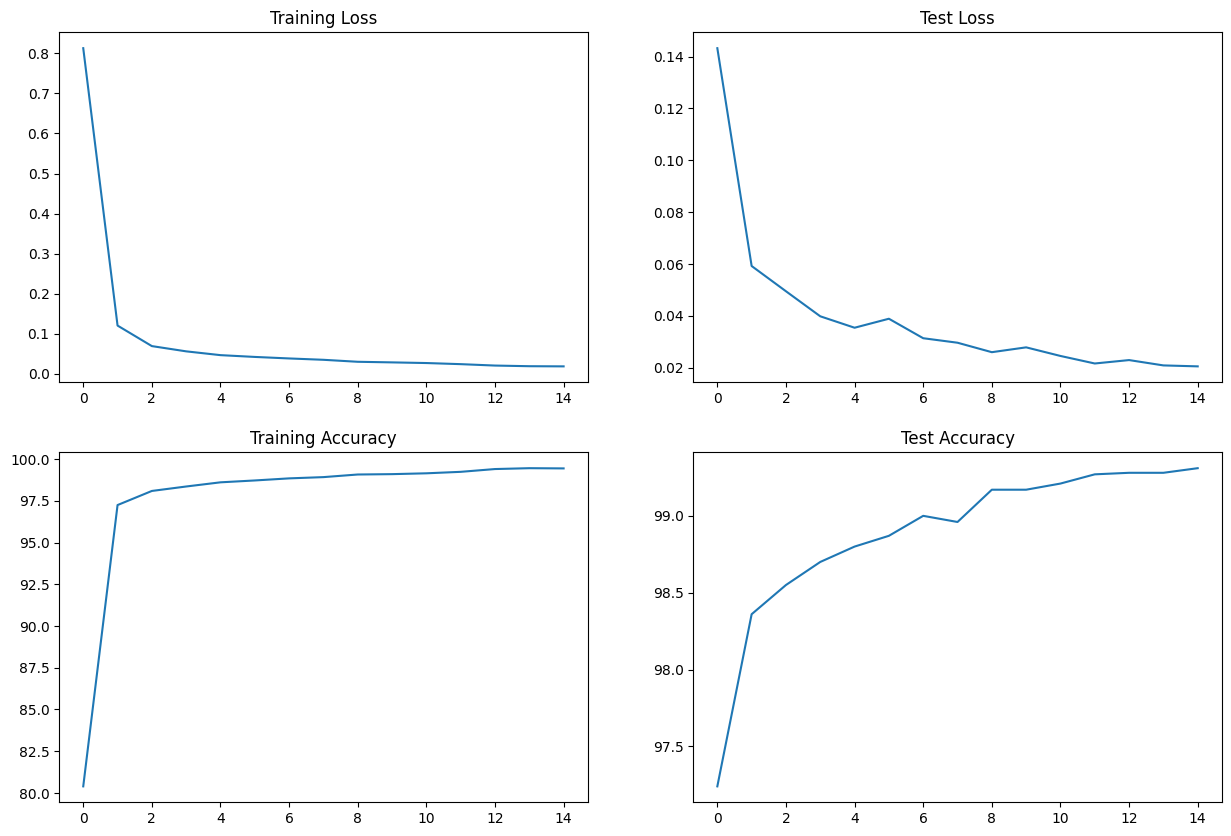

In [12]:
plot_metrics(train_losses7, train_acc7, test_losses7, test_acc7)

### Incorrect Predictions

In [13]:
def extract_incorrect_predictions(test_loader, model, device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])

  return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [14]:
incorrect_predictions = extract_incorrect_predictions(test_loader, model, device)

In [15]:
print(f'Total incorrect predictions are {len(incorrect_predictions)}')

Total incorrect predictions are 69


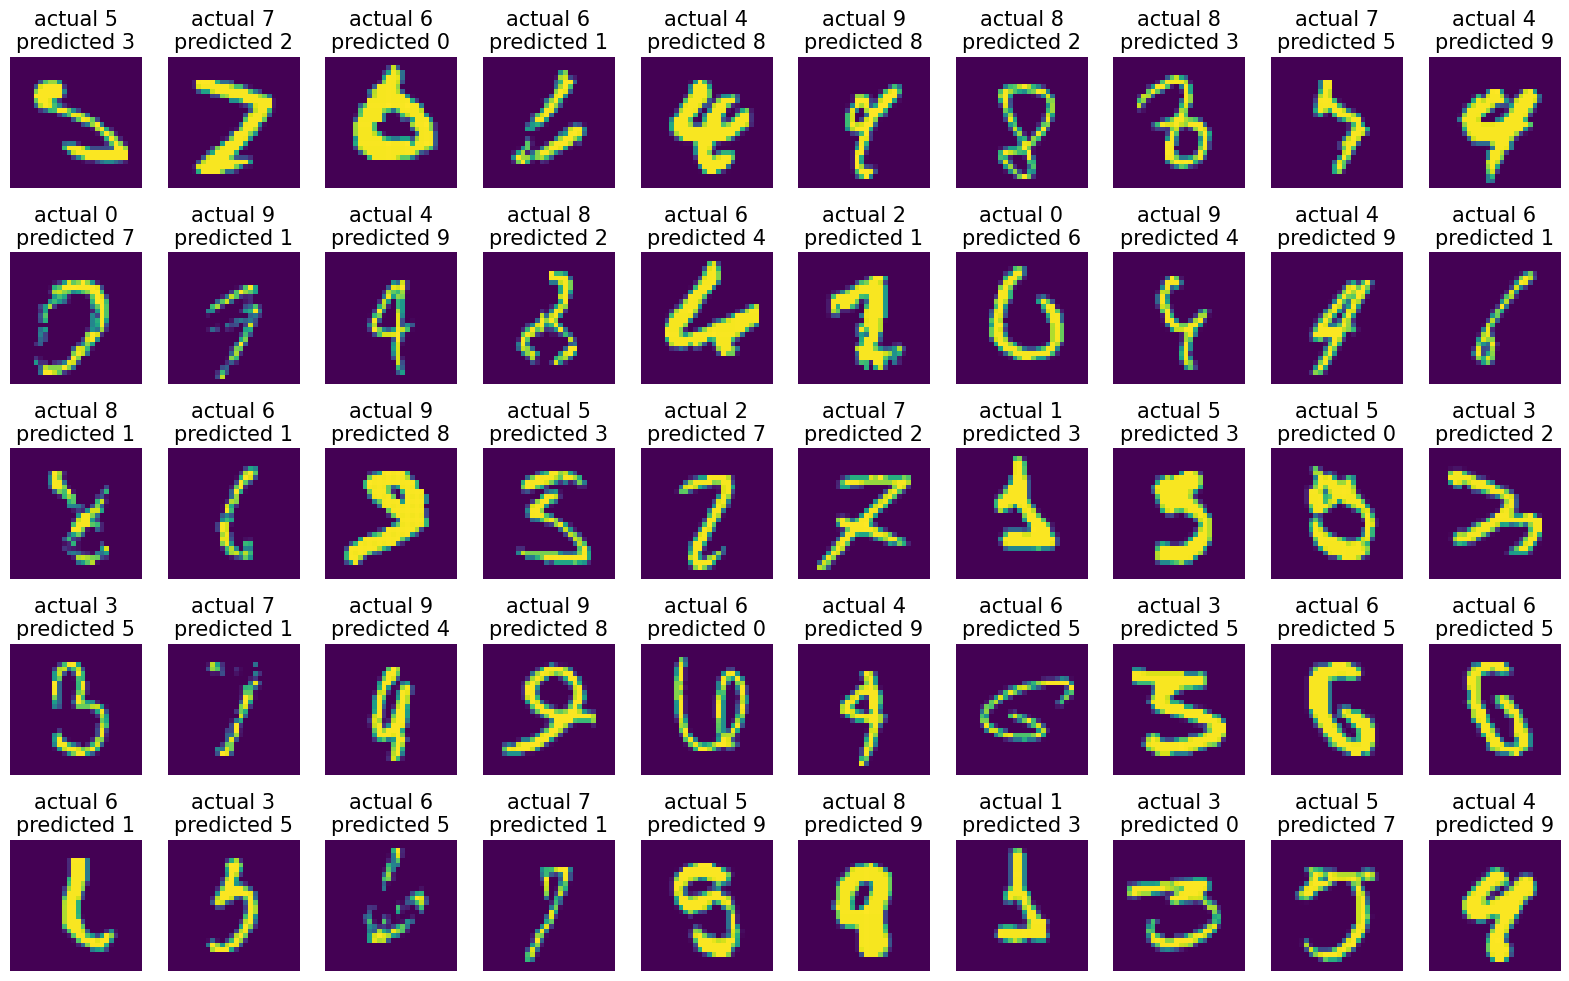

In [16]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(incorrect_predictions[:50]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()